## Environment Setup
Create the inventory management RL environment.

In [13]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [14]:
class InventoryManagement:
    def __init__(self):
        self.max_warehouse_level = 20
        self.max_order = 15
        self.max_demand = 15
        self.min_demand = 5
        self.state_space = [i for i in range(0, self.max_warehouse_level + 1)]
        self.action_space = [i for i in range(0, self.max_order + 1)]
        self.demand_space = [i for i in range(self.min_demand, self.max_demand + 1)]
        self.price = 10
        self.wholesale_price = 5
        self.holding_cost = 1
        self.lost_sale_cost = 1
        self.over_order_cost = 3
        self.transition_function = self.create_transition_function()

    def create_transition_function(self):
        transition_function = {}
        for state in self.state_space:
            for action in self.action_space:
                next_state = state + action
                if next_state > self.max_warehouse_level:
                    next_state = self.max_warehouse_level
                    reward = -self.over_order_cost * (
                        state + action - self.max_warehouse_level
                    )
                else:
                    reward = 0
                transition_function[(state, action)] = (next_state, reward)
        return transition_function

    def step(self, state, action):
        demand = np.random.choice(self.demand_space)
        # print(state, demand, action)
        state = state[0][0]
        reward = (
            np.minimum(state, demand) * self.price
            - np.maximum(demand - state, 0) * self.lost_sale_cost
            - action * self.wholesale_price
            - np.maximum(state - demand, 0) * self.holding_cost
        )
        next_state, order_reward = self.transition_function[
            (np.maximum(state - demand, 0), action)
        ]
        return reward + order_reward, next_state

    def reset(self):
        return self.state_space[0]


## DQN Agent

In [15]:
env = InventoryManagement()
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.gamma = 0.95
        self.batch_size = 128
        self.memory = deque(maxlen=10000)
        self.model = DQN(state_space, action_space).to(device)
        self.optimizer = optim.Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss().to(device)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        state = torch.FloatTensor(state).to(device)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = map(np.array, zip(*minibatch))
        dones = np.zeros(self.batch_size)

        states = torch.tensor(states.reshape(-1, 1), dtype=torch.float32, device=device)
        next_states = torch.tensor(next_states.reshape(-1, 1), dtype=torch.float32, device=device)

        self.model.eval()
        next_state_values = self.model(next_states).detach().cpu().numpy()
        self.model.train()

        targets = rewards + self.gamma * (np.amax(next_state_values, axis=1)) * (1 - dones)

        targets_full = self.model(states)
        targets_pred = targets_full.clone()

        targets_full[torch.arange(self.batch_size), torch.tensor(actions, device=device)] = torch.tensor(targets, dtype=torch.float32, device=device)

        loss = self.MSE_loss(targets_pred, targets_full)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



def train_dqn(episode):
    loss = []
    action_space = len(env.action_space)
    state_space = 1

    max_steps = 500
    agent = Agent(state_space, action_space)
    action_np = np.zeros((episode, max_steps))
    reward_np = np.zeros((episode, max_steps))
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, [1, state_space])
        score = 0
        for i in range(max_steps):
            action = agent.act(state)
            reward, next_state = env.step(state, action)
            next_state = np.reshape(next_state, [1, state_space])
            agent.remember(state, action, reward, next_state)
            state = next_state
            agent.replay()
            score += reward
            action_np[e, i] = action
            reward_np[e, i] = reward
            if i == max_steps - 1:
                print("episode: {}/{}, score: {}".format(e, episode, score))
        loss.append(score)

    return loss, action_np, reward_np


## Training

episode: 0/100, score: 10439
episode: 1/100, score: 12515
episode: 2/100, score: 18914
episode: 3/100, score: 19727
episode: 4/100, score: 18769
episode: 5/100, score: 21184
episode: 6/100, score: 20335
episode: 7/100, score: 20932
episode: 8/100, score: 21186
episode: 9/100, score: 20616
episode: 10/100, score: 20143
episode: 11/100, score: 19595
episode: 12/100, score: 20244
episode: 13/100, score: 19691
episode: 14/100, score: 19443
episode: 15/100, score: 19467
episode: 16/100, score: 18723
episode: 17/100, score: 18681
episode: 18/100, score: 19065
episode: 19/100, score: 17760
episode: 20/100, score: 18490
episode: 21/100, score: 19603
episode: 22/100, score: 19540
episode: 23/100, score: 19711
episode: 24/100, score: 17082
episode: 25/100, score: 16083
episode: 26/100, score: 17388
episode: 27/100, score: 17440
episode: 28/100, score: 17879
episode: 29/100, score: 17582
episode: 30/100, score: 18459
episode: 31/100, score: 12296
episode: 32/100, score: 7995
episode: 33/100, scor

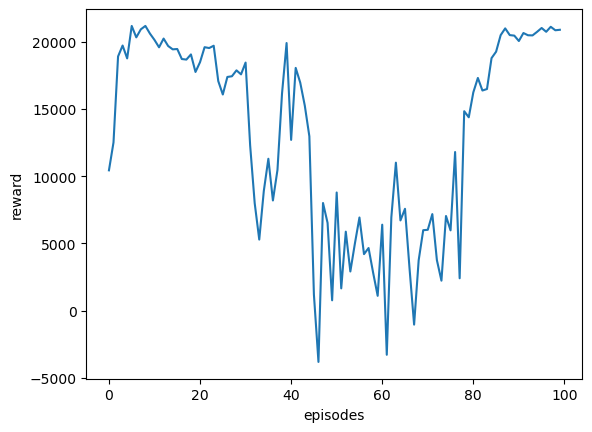

In [16]:
ep = 100
loss, action_np, reward_np = train_dqn(ep)
plt.plot([i for i in range(ep)], loss)
plt.xlabel("episodes")
plt.ylabel("reward")
plt.show()

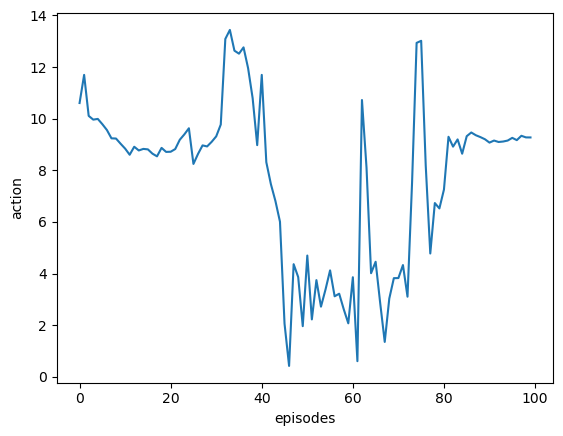

In [20]:
plt.plot([i for i in range(ep)], np.mean(action_np, axis=1))
plt.xlabel("episodes")
plt.ylabel("action")
plt.show()

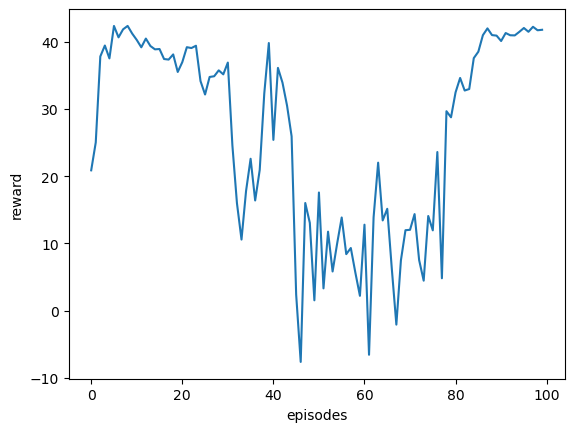

In [18]:
# Plot reward
plt.plot([i for i in range(ep)], np.mean(reward_np, axis=1))
plt.xlabel("episodes")
plt.ylabel("reward")
plt.show()